In [16]:
# Import necessary libraries

import torch
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Use cuda if it is available
device = "cuda" if torch.cuda.is_available() else "cpu"

In [17]:
# Use VGG-19
# VGG-19 is a CNN that is 19 layers deep that has been pretrained on more than a million images from the ImageNet database

model = models.vgg19(pretrained=True).features
for p in model.parameters():
    # We want to use the pretrained model, so we freeze the model's parameters, preventing them from being updated during training
    p.requires_grad = False
model.to(device)

print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [18]:
def model_activations(input, model):
    # 6 activation layers
    # Layers where the dimensions are changed
    layers = {
        "0": "conv1_1",
        "5": "conv2_1",
        "10": "conv3_1",
        "19": "conv4_1",
        "21": "conv4_2",
        "28": "conv5_1",
    }
    features = {}
    x = input
    x = x.unsqueeze(0)
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features

In [19]:
# Resize the image to 400x400, transform into a tensor, and normalize
transform = transforms.Compose(
    [
        transforms.Resize(400),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

In [20]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
# Make sure that you have a content.jpg and style.jpg image at your file path
path = "drive/My Drive/Machine Learning/neural_style_transfer/"

content = Image.open(path + "content.jpg").convert("RGB")
content = transform(content).to(device)
print("Content shape: ", content.shape)
style = Image.open(path + "style.jpg").convert("RGB")
style = transform(style).to(device)
print("Style shape: ", style.shape)

Content shape:  torch.Size([3, 400, 400])
Style shape:  torch.Size([3, 400, 400])


In [22]:
# Converts the image tensor to a format that can be outputed by MatPlotLib
def image_convert(image):
    x = image.to("cpu").clone().detach().numpy().squeeze()
    x = x.transpose(1, 2, 0)
    x = x * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    return np.clip(x, 0, 1)

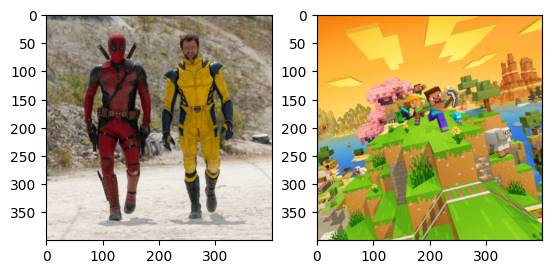

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(image_convert(content), label="Content")
ax2.imshow(image_convert(style), label="Style")
plt.show()

In [24]:
# Matrix multiplication of a feature with its transpose
def gram_matrix(imgfeature):
    _, d, h, w = imgfeature.size()
    imgfeature = imgfeature.view(d, h * w)
    gram_mat = torch.mm(imgfeature, imgfeature.t())

    return gram_mat

In [25]:
# The target image
# It should have the same dimensions as the content image
target = content.clone().requires_grad_(True).to(device)

# Get the features of the content and style images
style_features = model_activations(style, model)
content_features = model_activations(content, model)

In [26]:
# Content is captured by higher layers; style is captured by lower layers
# Experiment with these weights
style_weight_measurements = {
    "conv1_1": 1.0,
    "conv2_1": 0.8,
    "conv3_1": 0.4,
    "conv4_1": 0.2,
    "conv5_1": 0.1,
}

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

In [27]:
# Experiment with the weights, number of epochs, and learning rate for different results
# To accurately capture style, the style weight has to be a lot higher than the content weight
content_weight = 1e8
style_weight = 1e5

print_after = 10
epochs = 100
learning_rate = 0.02

# Use the Adam Optimizer
optimizer = torch.optim.Adam([target], lr=learning_rate)

In [28]:
# Iterate for the number of epochs (Optimization)
for i in range(1, epochs + 1):
    target_features = model_activations(target, model)

    # Get the average loss which is calculated by the (content - target)^2
    content_loss = torch.mean(
        (content_features["conv4_2"] - target_features["conv4_2"]) ** 2
    )

    style_loss = 0

    # Iterate through each of the style weights
    for layer in style_weight_measurements:
        style_gram = style_grams[layer]
        target_gram = target_features[layer]
        _, d, w, h = target_gram.shape
        target_gram = gram_matrix(target_gram)

        style_loss += (
            (
                style_weight_measurements[layer]
                * torch.mean((target_gram - style_gram) ** 2)
            )
            / d
            * w
            * h
        )  # Normalize with depth, width, and height

    total_loss = (content_weight * content_loss) + (style_weight * style_loss)

    # Print every 10th epoc
    if i % 10 == 0:
        print(f"Epoch: {i} | {total_loss}")

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # Display the image after print_after epochs
    if i % print_after == 0:
        plt.imshow(image_convert(target), label="Epoch " + str(i))
        plt.show()
        plt.imsave(str(i) + ".png", image_convert(target), format="png")